In [2]:
# importing packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

2023-01-22 11:36:10.353923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 11:36:10.510114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 11:36:10.510148: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 11:36:11.009955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [6]:
import os


In [7]:
filepath = '/home/roshankondapalli/Documents/Textbooks1/Sci_Computing/Databases/Practice_Datasets/Sloan_SDSS17/star_classification.csv'

In [8]:
df = pd.read_csv(filepath)
df.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
dfs = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID','plate','spec_obj_ID'], axis = 1)

In [11]:
dfs = dfs.rename(columns={'u':'Ultraviolet Filter', 'r':'Red Filter', 'g': 'Green Filter',
                          'i': 'Near Infrared Filter', 'z':'Infrared Filter',
                          'redshift':'Redshift','class':'Class'})

In [12]:
#sns.heatmap(dfs.corr, cmap=sns.cubehelix_palette(as_cmap=True))

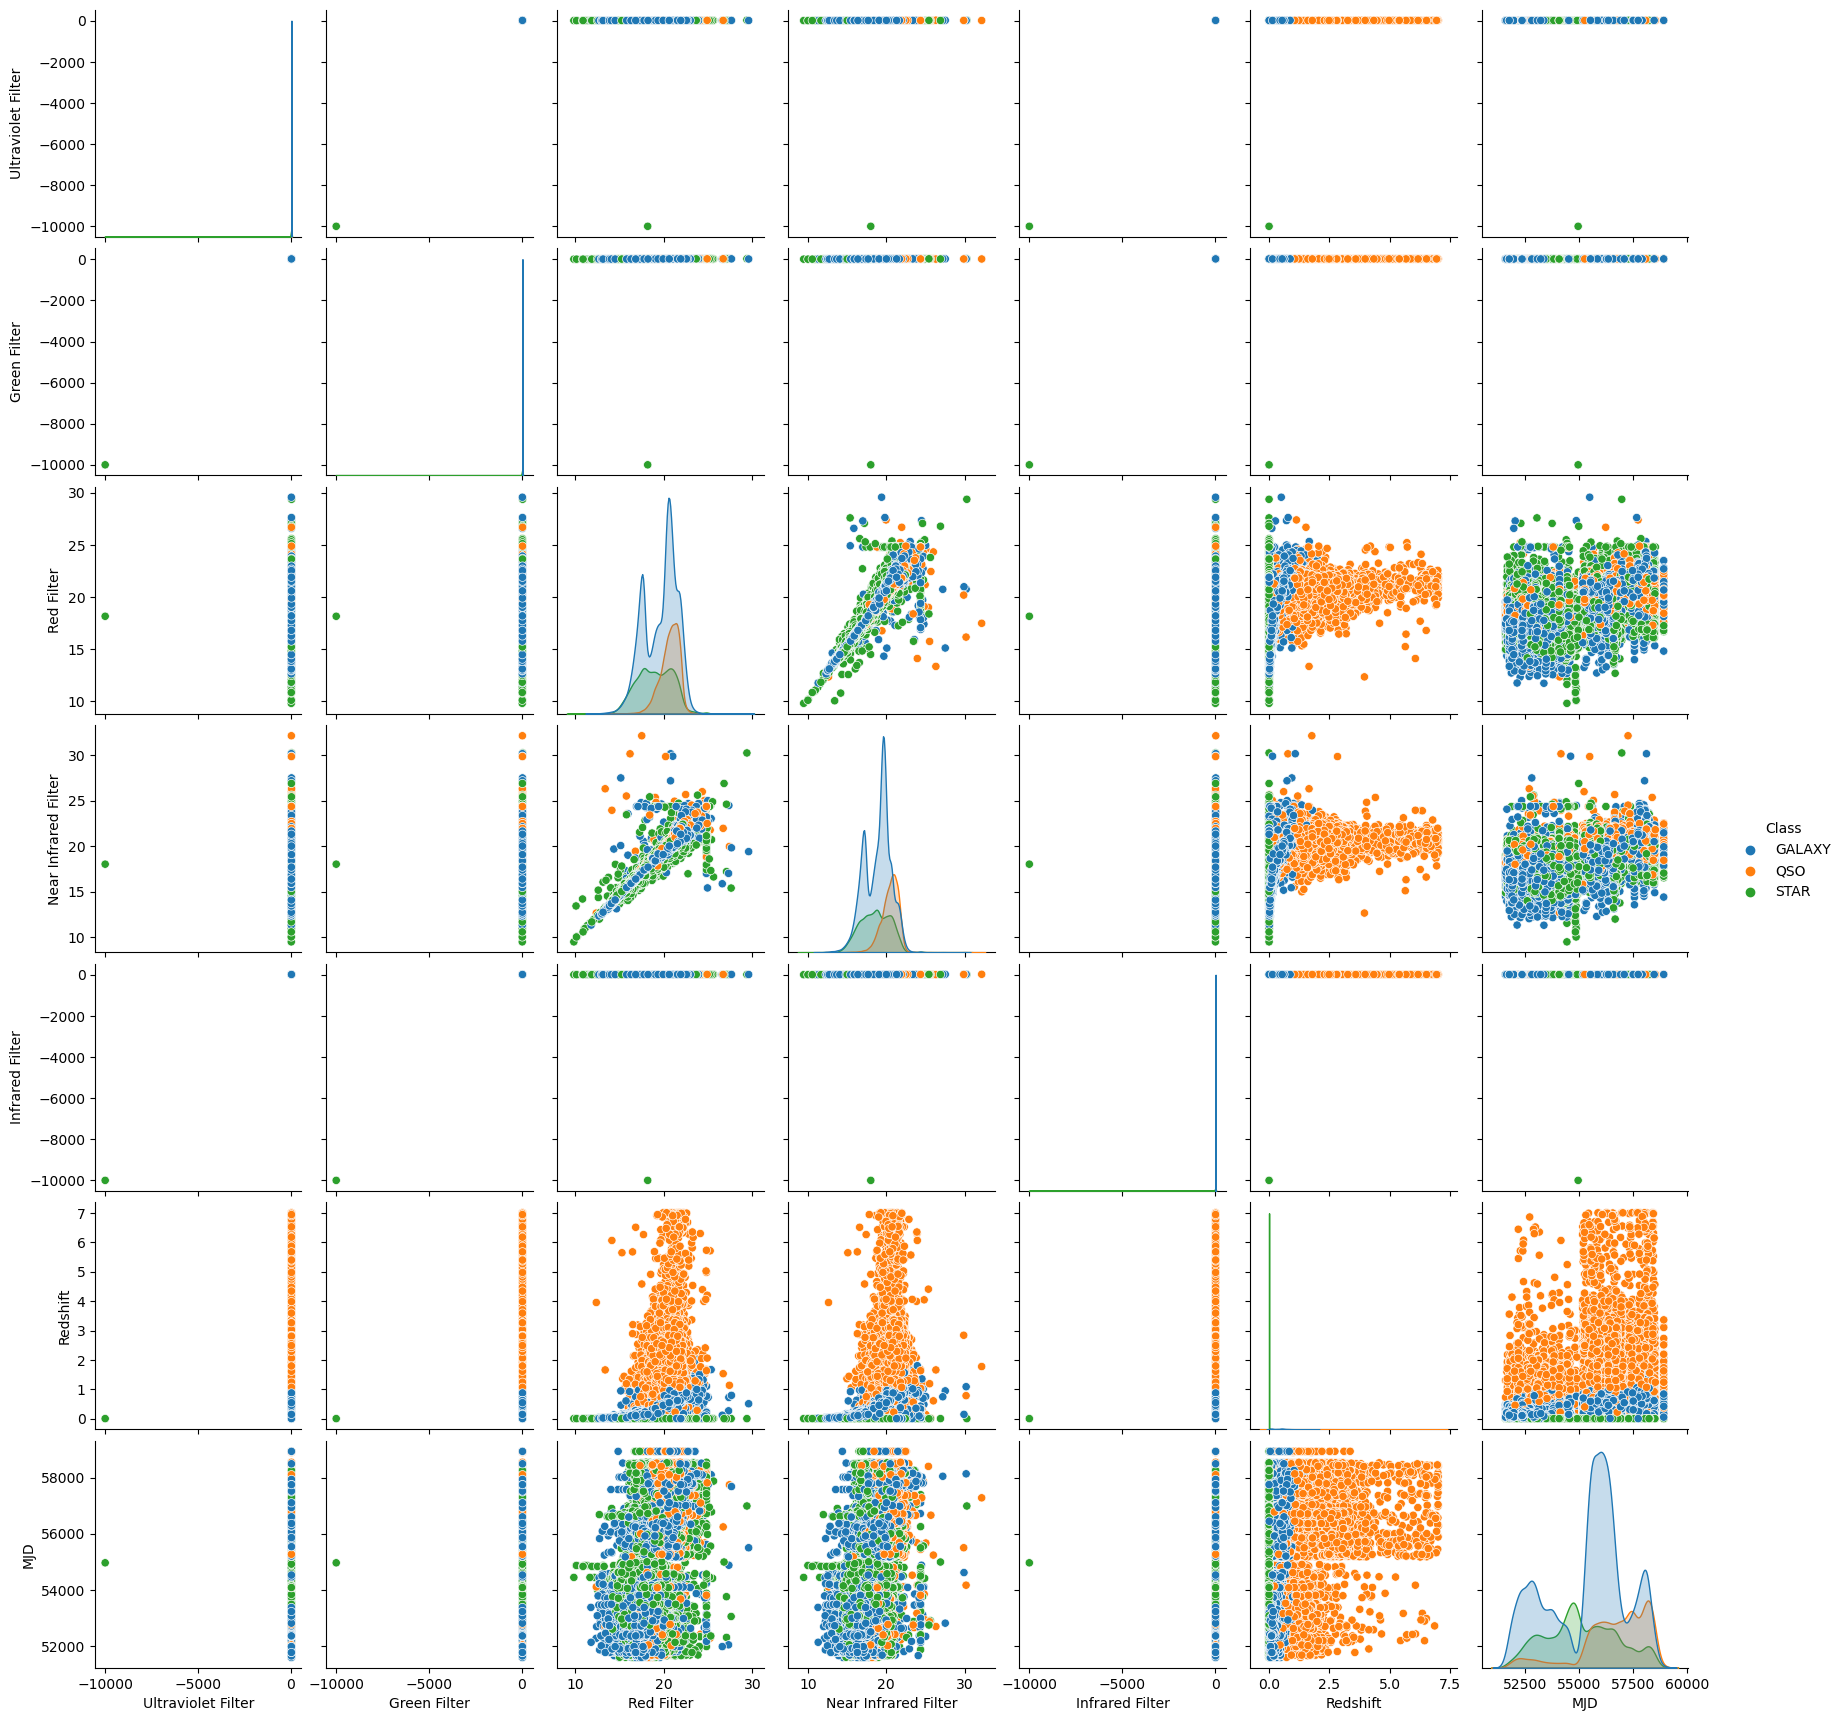

In [13]:
sns.pairplot(dfs, hue="Class")

In [14]:
plt.savefig("pairplotsloan.png")

<Figure size 640x480 with 0 Axes>

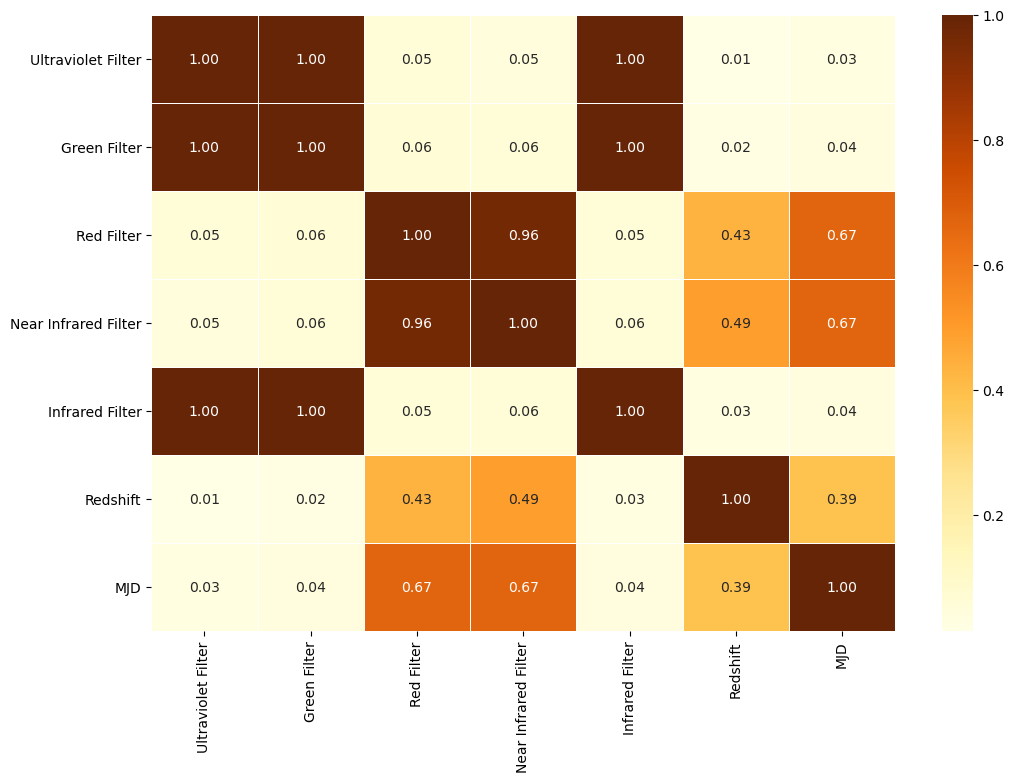

In [15]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(dfs.corr(), cmap=sns.color_palette("YlOrBr", as_cmap=True), annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show() 

In [15]:
dfs.head()

,Ultraviolet Filter,Green Filter,Red Filter,Near Infrared Filter,Infrared Filter,Class,Redshift,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,58158
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,55592
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,56187


In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [17]:
stellar = dfs.copy()

In [18]:
X = stellar.drop(['Class'], axis = 1)
Y = stellar.loc[:, 'Class'].values

In [19]:
X.head()

,Ultraviolet Filter,Green Filter,Red Filter,Near Infrared Filter,Infrared Filter,Redshift,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,56354
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,58158
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,55592
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,58039
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,56187


In [20]:
rb = RobustScaler()
X = rb.fit_transform(X)

In [22]:
#lb = LabelEncoder()
#Y = lb.fit_transform(Y)
#Y = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)


In [23]:
lb = LabelBinarizer()
Y = lb.fit_transform(Y)


In [24]:
sm = SMOTE(random_state=42)
X, Y = sm.fit_resample(X,Y)
#print('Resampled dataset %s' % Counter(Y))

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = None) 

In [26]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Neural Network #from [18]

Neural Networks


In [27]:
from tensorflow.keras.layers import Dropout

In [28]:
#Network architecture

model = Sequential()
#model.add(Dropout(.28))
model.add(Dense(50, input_shape = (7,), activation = 'sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(3, activation = 'softmax'))

2023-01-21 12:01:55.148170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-21 12:01:55.148248: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-21 12:01:55.148310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2023-01-21 12:01:55.148788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                560       
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                4260      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 183       
                                                                 
Total params: 5,003
Trainable params: 5,003
Non-trainable params: 0
_________________________________________________________________


In [30]:
#SGD Optimizer

model.compile(SGD(.003), "categorical_crossentropy", metrics=["accuracy"])
H_SGD = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100)

Epoch 1/100
4180/4180 [==============================] - 6s 1ms/step - loss: 1.1005 - accuracy: 0.3987 - val_loss: 0.9640 - val_accuracy: 0.6213
Epoch 2/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.9423 - accuracy: 0.5152 - val_loss: 0.7846 - val_accuracy: 0.7146
Epoch 3/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.8089 - accuracy: 0.5948 - val_loss: 0.6653 - val_accuracy: 0.7417
Epoch 4/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.7283 - accuracy: 0.6412 - val_loss: 0.6049 - val_accuracy: 0.7670
Epoch 5/100
4180/4180 [==============================] - 5s 1ms/step - loss: 0.6812 - accuracy: 0.6670 - val_loss: 0.5702 - val_accuracy: 0.7856
Epoch 6/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.6483 - accuracy: 0.6872 - val_loss: 0.5426 - val_accuracy: 0.8019
Epoch 7/100
4180/4180 [==============================] - 5s 1ms/step - loss: 0.6218 - accuracy: 0.7024 - val_loss: 0.5192 - val_ac

In [51]:
print("Classification Report: ")
predictions = model.predict(X_test, batch_size=128)
print(classification_report(Y_test.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in lb.classes_]))

Classification Report: 
349/349 [==============================] - 0s 819us/step
              precision    recall  f1-score   support

      GALAXY       0.93      0.93      0.93     14915
         QSO       0.97      0.92      0.95     14930
        STAR       0.95      1.00      0.98     14739

    accuracy                           0.95     44584
   macro avg       0.95      0.95      0.95     44584
weighted avg       0.95      0.95      0.95     44584



In [40]:
from sklearn.metrics import confusion_matrix

In [42]:
rfc_matrix = confusion_matrix(H_SGD,X_test,Y_test,labels=['GALAXY','QSO','STAR'])
plt.show()
plt.savefig("rfc_matrix_pca.png")

TypeError: confusion_matrix() takes 2 positional arguments but 3 positional arguments (and 1 keyword-only argument) were given

In [1]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H_SGD.history["loss"], label="Training Loss")
plt.plot(np.arange(0, 100), H_SGD.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, 100), H_SGD.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, 100), H_SGD.history["val_accuracy"], label="Validation Accuracty")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig('first_plot.png')

NameError: name 'plt' is not defined

In [43]:
#Network architecture

model_1 = Sequential()
#model.add(Dropout(.28))
model_1.add(Dense(50, input_shape = (7,), activation = 'sigmoid'))
model_1.add(Dropout(0.4))
model_1.add(Dense(50, activation='sigmoid'))
model_1.add(Dropout(0.4))
model_1.add(Dense(3, activation = 'softmax'))

In [44]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                400       
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 153       
                                                                 
Total params: 3,103
Trainable params: 3,103
Non-trainable params: 0
_________________________________________________________________


In [45]:
#RMSProp

model_1.compile(RMSprop(.003), "categorical_crossentropy", metrics=["accuracy"])
H_RMS = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100)

Epoch 1/100
4180/4180 [==============================] - 6s 2ms/step - loss: 0.2541 - accuracy: 0.9076 - val_loss: 0.1893 - val_accuracy: 0.9371
Epoch 2/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2529 - accuracy: 0.9075 - val_loss: 0.1890 - val_accuracy: 0.9366
Epoch 3/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2545 - accuracy: 0.9066 - val_loss: 0.1884 - val_accuracy: 0.9370
Epoch 4/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2501 - accuracy: 0.9083 - val_loss: 0.1870 - val_accuracy: 0.9387
Epoch 5/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2509 - accuracy: 0.9079 - val_loss: 0.1874 - val_accuracy: 0.9367
Epoch 6/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2497 - accuracy: 0.9084 - val_loss: 0.1860 - val_accuracy: 0.9387
Epoch 7/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2502 - accuracy: 0.9093 - val_loss: 0.1853 - val_ac

In [46]:
print("[INFO] evaluating network...")
predictions = model_1.predict(X_test, batch_size=128)
print(classification_report(Y_test.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in lb.classes_]))

[INFO] evaluating network...
349/349 [==============================] - 0s 875us/step
              precision    recall  f1-score   support

      GALAXY       0.37      0.61      0.46     14915
         QSO       0.00      0.00      0.00     14930
        STAR       0.02      0.03      0.03     14739

    accuracy                           0.21     44584
   macro avg       0.13      0.21      0.16     44584
weighted avg       0.13      0.21      0.16     44584



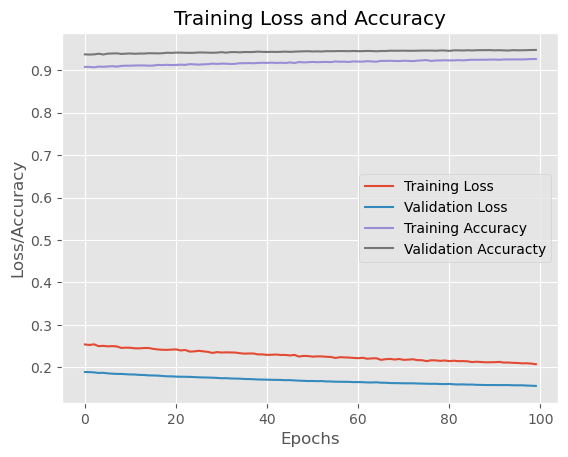

In [47]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H_RMS.history["loss"], label="Training Loss")
plt.plot(np.arange(0, 100), H_RMS.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, 100), H_RMS.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, 100), H_RMS.history["val_accuracy"], label="Validation Accuracty")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('first1_plot.png')

In [48]:
model_2 = Sequential()
#model.add(Dropout(.28))
model_2.add(Dense(5, input_shape = (7,), activation = 'sigmoid'))
model_2.add(Dropout(0.4))
model_2.add(Dense(50, activation='sigmoid'))
model_2.add(Dropout(0.4))
model_2.add(Dense(3, activation = 'softmax'))

In [49]:
#Adam Optimizer

model_2.compile(Adam(.003), "categorical_crossentropy", metrics=["accuracy"])
H_AD = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100)

Epoch 1/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2092 - accuracy: 0.9254 - val_loss: 0.1566 - val_accuracy: 0.9473
Epoch 2/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2086 - accuracy: 0.9263 - val_loss: 0.1561 - val_accuracy: 0.9479
Epoch 3/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2089 - accuracy: 0.9264 - val_loss: 0.1562 - val_accuracy: 0.9474
Epoch 4/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2084 - accuracy: 0.9259 - val_loss: 0.1559 - val_accuracy: 0.9476
Epoch 5/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2078 - accuracy: 0.9269 - val_loss: 0.1562 - val_accuracy: 0.9472
Epoch 6/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2068 - accuracy: 0.9269 - val_loss: 0.1561 - val_accuracy: 0.9471
Epoch 7/100
4180/4180 [==============================] - 6s 1ms/step - loss: 0.2066 - accuracy: 0.9268 - val_loss: 0.1554 - val_ac

In [ ]:
print("[INFO] evaluating network...")
predictions = model_2.predict(X_test, batch_size=128)
print(classification_report(Y_test.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in lb.classes_]))

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H_AD.history["loss"], label="Training Loss")
plt.plot(np.arange(0, 100), H_AD.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, 100), H_AD.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, 100), H_AD.history["val_accuracy"], label="Validation Accuracty")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('first2_plot.png')